In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.1 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.preprocessing import RobustScaler, LabelBinarizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import optuna
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
hamData = pd.read_csv("./drive/MyDrive/IA Python/deepLearning/HAM10000_metadata.csv", sep=",")

hamData.head(5).T

,0,1,2,3,4
lesion_id,HAM_0000118,HAM_0000118,HAM_0002730,HAM_0002730,HAM_0001466
image_id,ISIC_0027419,ISIC_0025030,ISIC_0026769,ISIC_0025661,ISIC_0031633
dx,bkl,bkl,bkl,bkl,bkl
dx_type,histo,histo,histo,histo,histo
age,80.0,80.0,80.0,80.0,75.0
sex,male,male,male,male,male
localization,scalp,scalp,scalp,scalp,ear


In [5]:
hamData.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [6]:
hamData_encoded = pd.get_dummies(hamData, columns=['sex', 'localization'], drop_first=True)

hamData_encoded.T

,0,1,2,3,4,5,6,7,8,9,...,10005,10006,10007,10008,10009,10010,10011,10012,10013,10014
lesion_id,HAM_0000118,HAM_0000118,HAM_0002730,HAM_0002730,HAM_0001466,HAM_0001466,HAM_0002761,HAM_0002761,HAM_0005132,HAM_0005132,...,HAM_0005579,HAM_0004034,HAM_0001565,HAM_0001576,HAM_0005705,HAM_0002867,HAM_0002867,HAM_0002867,HAM_0000239,HAM_0003521
image_id,ISIC_0027419,ISIC_0025030,ISIC_0026769,ISIC_0025661,ISIC_0031633,ISIC_0027850,ISIC_0029176,ISIC_0029068,ISIC_0025837,ISIC_0025209,...,ISIC_0028393,ISIC_0024948,ISIC_0028619,ISIC_0033705,ISIC_0031430,ISIC_0033084,ISIC_0033550,ISIC_0033536,ISIC_0032854,ISIC_0032258
dx,bkl,bkl,bkl,bkl,bkl,bkl,bkl,bkl,bkl,bkl,...,akiec,akiec,akiec,akiec,akiec,akiec,akiec,akiec,akiec,mel
dx_type,histo,histo,histo,histo,histo,histo,histo,histo,histo,histo,...,histo,histo,histo,histo,histo,histo,histo,histo,histo,histo
age,80.0,80.0,80.0,80.0,75.0,75.0,60.0,60.0,70.0,70.0,...,80.0,55.0,60.0,60.0,75.0,40.0,40.0,40.0,80.0,70.0
sex_male,True,True,True,True,True,True,True,True,False,False,...,True,False,False,True,False,True,True,True,True,False
sex_unknown,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
localization_acral,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
localization_back,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
localization_chest,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
# Análisis de distribución de clases
class_distribution = hamData['dx'].value_counts()
print("Distribución de clases:")
print(class_distribution)
print("\nPorcentajes:")
print(class_distribution / len(hamData) * 100)
# Análisis por sexo
sex_distribution = hamData['sex'].value_counts()
print("\nDistribución por sexo:")
print(sex_distribution)
print("\nPorcentajes:")
print(sex_distribution / len(hamData) * 100)

Distribución de clases:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Porcentajes:
dx
nv       66.949576
mel      11.113330
bkl      10.973540
bcc       5.132302
akiec     3.265102
vasc      1.417873
df        1.148278
Name: count, dtype: float64

Distribución por sexo:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Porcentajes:
sex
male       53.979031
female     45.451822
unknown     0.569146
Name: count, dtype: float64


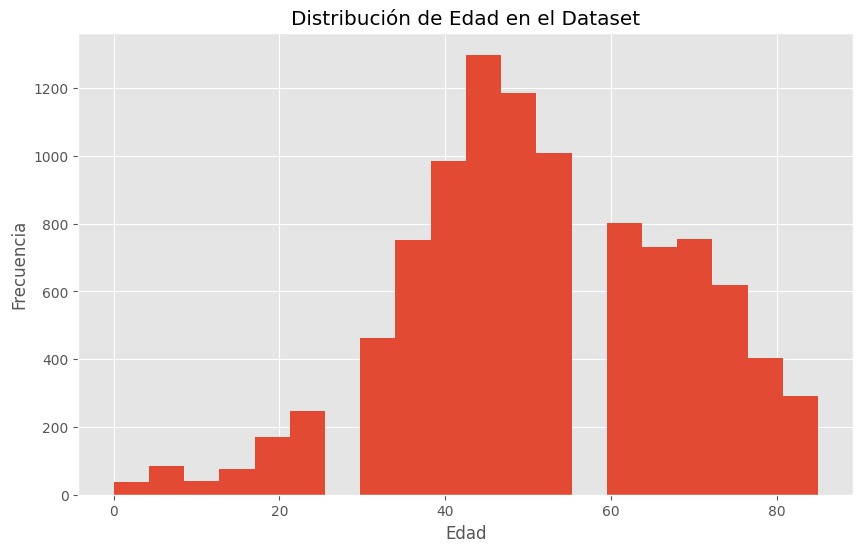

In [34]:
# Análisis por grupos de edad
plt.figure(figsize=(10,6))
plt.hist(hamData['age'], bins=20)
plt.title('Distribución de Edad en el Dataset')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

In [36]:
# Estratificación por múltiples variables
from sklearn.model_selection import StratifiedKFold

hamData_encoded.fillna(0, inplace=True)
X = hamData_encoded.drop(['dx','image_id','lesion_id','dx_type'], axis=1).values
y = hamData_encoded['dx'].values

hamData['strat'] = hamData['dx'] + '_' + hamData['sex'] + '_' + pd.qcut(hamData['age'], q=5).astype(str)
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=hamData['strat'])

scaler = RobustScaler()
X_scaled = scaler.fit_transform(x_train)
X_val_scaled = scaler.transform(x_val)


lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)

In [37]:
X_scaled = X_scaled.astype(float)
X_val_scaled = X_val_scaled.astype(float)

# Verificar si existen NaN o Inf en los datos de entrada y salida
if np.isnan(x_train.astype(float)).any():
    print("Se encontraron valores NaN en X_scaled")
elif np.isinf(x_train.astype(float)).any():
    print("Se encontraron valores Inf en X_scaled")
if np.isnan(y_val_encoded).any() or np.isinf(y_val_encoded).any():
    print("Se encontraron valores NaN o Inf en y_train")

print(f"Tamaño de y_train_encoded: {y_train_encoded.shape[0]}")
print(f"Tamaño de X_scaled: {X_scaled.shape[0]}")
print(f"Tamaño de y_val_encoded: {y_val_encoded.shape[0]}")
print(f"Tamaño de X_val_scaled: {X_val_scaled.shape[0]}")

Tamaño de y_train_encoded: 8012
Tamaño de X_scaled: 8012
Tamaño de y_val_encoded: 2003
Tamaño de X_val_scaled: 2003


In [38]:
def train_deep_net(activation_function, learning_rate, batch_size, num_epochs,lr_decay):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(200, activation=activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation=activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(60, activation=activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(30, activation=activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(y_train_encoded.shape[1], input_shape=(X_scaled.shape[1],), activation="softmax"))

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  opt = Adam(learning_rate=learning_rate, weight_decay=lr_decay)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  print(f"Tamaño de y_train_encoded: {y_train_encoded.shape[0]}")
  print(f"Tamaño de X_scaled: {X_scaled.shape[0]}")
  print(f"Tamaño de y_val_encoded: {y_val_encoded.shape[0]}")
  print(f"Tamaño de X_val_scaled: {X_val_scaled.shape[0]}")
  # Entrenando la solución
  H = model.fit(X_scaled, y_train_encoded, validation_data=(X_val_scaled, y_val_encoded), epochs=num_epochs, batch_size=batch_size)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_val_scaled, batch_size=batch_size)
  print(classification_report(y_val_encoded.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  return model

[INFO]: Entrenando red neuronal...
Tamaño de y_train_encoded: 8012
Tamaño de X_scaled: 8012
Tamaño de y_val_encoded: 2003
Tamaño de X_val_scaled: 2003
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6217 - loss: 1.2609 - val_accuracy: 0.6945 - val_loss: 0.9724
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6738 - loss: 1.0539 - val_accuracy: 0.6890 - val_loss: 0.9536
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6755 - loss: 1.0328 - val_accuracy: 0.6755 - val_loss: 0.9676
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6779 - loss: 1.0061 - val_accuracy: 0.6940 - val_loss: 0.9614
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6815 - loss: 0.9985 - val_accuracy: 0.6875 - val_loss: 0.9453
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6804 - loss: 0.9830 - val_accuracy: 0.6970 - val_loss: 0.9443
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6850 - loss: 0.9786 - val_accuracy: 0.6990 - val_loss: 0.9398
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6829 - loss: 0.9961 - val_accuracy: 0.6945 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


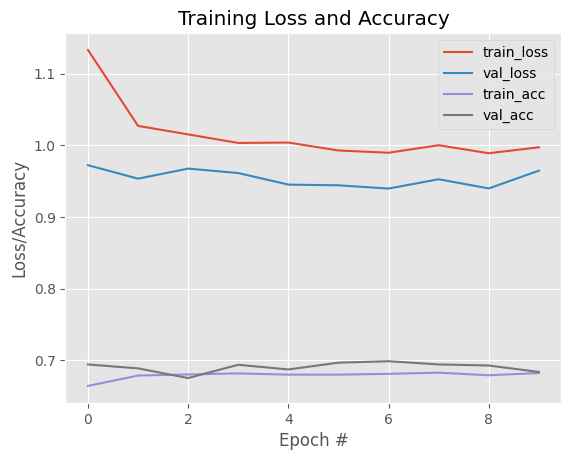

In [39]:
act = tf.nn.relu
learning_rate = 0.01
lr_decay = 1e-4
num_epochs = 10
batch_size = 64
model_tabular = train_deep_net(act, learning_rate, batch_size, num_epochs,lr_decay)

In [11]:
model_tabular.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 17)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60)                  │           6,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,423 (372.75 KB)

 Trainable params: 31,807 (124.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,616 (248.50 KB)

In [12]:
def objective(trial):
    # Definir el espacio de búsqueda de parámetros
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh','sigmoid'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 5, 50, 100)

    # Construye el modelo
    model = Sequential()
    model.add(Dense(256, activation=activation_function, input_shape=(X_scaled.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation=activation_function))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=activation_function))
    model.add(Dropout(0.5))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

    # Compila el modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Entrena el modelo (usamos validación para evitar overfitting)
    history = model.fit(X_scaled, y_train_encoded,
                        validation_data=(X_val_scaled, y_val_encoded),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        verbose=0)

    # Obtiene la precisión en el conjunto de validación
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy  # Maximize accuracy



In [ ]:
# Crea una instancia de estudio de Optuna
study = optuna.create_study(direction='maximize', study_name="deep_learning_hyperparameter_optimization")

# Configura el número máximo de iteraciones (búsquedas)
n_trials = 20  # Puedes ajustar esto según tus recursos

# Ejecuta la búsqueda de hiperparámetros
study.optimize(objective, n_trials=n_trials)

# Resumen del estudio
print("Mejores parámetros encontrados:")
print(study.best_params)

print(f"Mejor precisión en validación: {100 * study.best_value:.2f}%")


[I 2025-03-30 10:27:33,316] A new study created in memory with name: deep_learning_hyperparameter_optimization
<ipython-input-19-ffe7c5b06059>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
<ipython-input-19-ffe7c5b06059>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_epochs = trial.suggest_int('num_epochs', 5, 50, 100)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 50] and step=100, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
[I 2025-03-30 10:27:42,436] Trial 0 finished with value: 0.7009485960006714 and parameters: {'activation_function': 'relu', 'learning

Mejores parámetros encontrados:
{'activation_function': 'relu', 'learning_rate': 0.0015304198719795583, 'batch_size': 32, 'num_epochs': 5}
Mejor precisión en validación: 70.59%


# Hito 2 Modelo 2D (imágenes):
### Resolver el problema considerando la información presente en las imágenes empleando para ello al menos una red convolucional.

In [13]:
hmnistData = pd.read_csv("./drive/MyDrive/IA Python/deepLearning/hmnist_28_28_RGB.csv", sep=",")

hmnistData.head(5).T

,0,1,2,3,4
pixel0000,192,25,192,38,158
pixel0001,153,14,138,19,113
pixel0002,193,30,153,30,139
pixel0003,195,68,200,95,194
pixel0004,155,48,145,59,144
...,...,...,...,...,...
pixel2348,166,28,142,17,149
pixel2349,185,25,136,25,109
pixel2350,154,14,104,12,78
pixel2351,177,27,117,15,92


In [14]:
X = hmnistData.drop('label', axis=1).values
y = hmnistData['label'].values

# Dividir los datos en entrenamiento (80%) y prueba/validación (20%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el conjunto de prueba/validación en prueba (10%) y validación (10%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

unique_labels = hmnistData['label'].unique()

In [15]:
# Centramos los datos (le restamos la media)
X_train_mean = np.mean(X_train, axis=0)
X_train_cent = X_train - X_train_mean

# Normalizamos
X_train_std = np.std(X_train, axis=0)
X_train_norm = X_train_cent / X_train_std

X_test_norm = (X_test - X_train_mean) / X_train_std
X_val_norm = (X_val - X_train_mean) / X_train_std

# y_train_encoded = to_categorical(y_train_encoded, num_classes=len(unique_labels))
# y_val_encoded = to_categorical(y_val_encoded, num_classes=len(unique_labels))

In [16]:
print(f"Tamaño de X_train_norm: {X_train_norm.shape[0]}")
print(f"Tamaño de X_test_norm: {X_test_norm.shape[0]}")
print(f"Tamaño de X_val_norm: {X_val_norm.shape[0]}")

X_train_reshaped = X_train_norm.reshape(-1, 28, 28, 3)  # Ajusta estos valores si es necesario
X_test_reshaped = X_test_norm.reshape(-1, 28, 28, 3)
X_val_reshaped = X_val_norm.reshape(-1, 28, 28, 3)

print(f"Tamaño de X_train_reshaped: {X_train_reshaped.shape}")
print(f"Tamaño de X_test_reshaped: {X_test_reshaped.shape}")
print(f"Tamaño de X_val_reshaped: {X_val_reshaped.shape}")

Tamaño de X_train_norm: 8012
Tamaño de X_test_norm: 1002
Tamaño de X_val_norm: 1001
Tamaño de X_train_reshaped: (8012, 28, 28, 3)
Tamaño de X_test_reshaped: (1002, 28, 28, 3)
Tamaño de X_val_reshaped: (1001, 28, 28, 3)


In [17]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

P =0.25

model_img = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_constraint=max_norm(3)),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')  # O 'sigmoid' si es un problema de clasificación binaria
])

# Compilamos el modelo
model_img.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor="val_loss", min_delta=0.001, patience=4, verbose=0, mode="auto")]

# Entrenamos el modelo
# Aumentar los datos durante el entrenamiento
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model_img.fit(
    datagen.flow(X_train_reshaped, to_categorical(Y_train), batch_size=128),
    epochs=50,
    validation_data=(X_val_reshaped, to_categorical(Y_val)),
    callbacks=[early_stopping],  # Incluimos early stopping en los callbacks
    verbose=1
)

# Evaluamos el modelo
scores = model_img.evaluate(X_test_reshaped, to_categorical(Y_test))


print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.4060 - loss: 1.7302 - val_accuracy: 0.4126 - val_loss: 1.8523
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.6179 - loss: 1.0925 - val_accuracy: 0.5025 - val_loss: 1.6604
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.6504 - loss: 1.0040 - val_accuracy: 0.6124 - val_loss: 1.3320
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.6721 - loss: 0.9254 - val_accuracy: 0.6663 - val_loss: 1.0726
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.6673 - loss: 0.9189 - val_accuracy: 0.7013 - val_loss: 0.8933
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.6827 - loss: 0.8745 - val_accuracy: 0.7063 - val_loss: 0.8259
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.6901 - loss: 0.8583 - val_accuracy: 0.7143 - val_loss: 0.7879
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.6943 - loss: 0.8504 - val_accu

In [18]:
model_img.evaluate(X_val_reshaped, to_categorical(Y_val))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7218 - loss: 0.7377


[0.7292041182518005, 0.7252747416496277]

In [19]:
model_img.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 490,455 (1.87 MB)

 Trainable params: 163,335 (638.03 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 326,672 (1.25 MB)

# Hito 3 - Estrategia late-fusion:
### Combinación aprendida de las predicciones realizadas por el modelo 1D y el modelo 2D desarrollados previamente para resolver el problema.

In [20]:
# Input shapes
tabular_input_shape = (17,)
vision_input_shape = (32, 32, 3)

In [21]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

def build_late_fusion_model():

  tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
  vision_input = Input(shape=vision_input_shape, name="vision_input")

  tabular_pred = model_tabular(tabular_input)
  vision_pred = model_img(vision_input)

  # Fusión de las probabilidades concatenadas
  merged = Concatenate()([tabular_pred, vision_pred])

  # Clasificador final
  output = Dense(3, activation="softmax", name="final_output")(merged)

  # Definición final del modelo con nuevo classificador al final
  late_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
  return late_fusion_model

model_late_fusion = build_late_fusion_model()
model_late_fusion.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 17)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 7)              │         31,807 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 7)              │        163,783 │ vision_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 14)             │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_output (Dense)      │ (None, 3)              │             45 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 195,635 (764.20 KB)

 Trainable params: 195,187 (762.45 KB)

 Non-trainable params: 448 (1.75 KB)

# Hito 4 - Estrategia early-fusion:
### Combinación aprendida de las características realizadas por el modelo 1D y el modelo 2D desarrollados previamente para resolver el problema.


In [23]:

def build_early_fusion_model():
  # Inputs
  tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
  vision_input = Input(shape=vision_input_shape, name="vision_input")

  tabular_intermediate = Model(
    inputs=model_tabular.input, outputs=model_tabular.get_layer('dense_3').output)
  vision_intermediate = Model(
    inputs=model_img.input, outputs=model_img.get_layer('dense_5').output)

  tabular_features = tabular_intermediate(tabular_input)
  vision_features = vision_intermediate(vision_input)

  # Fusionamos la representación de ambas modalidades
  merged = Concatenate()([tabular_features, vision_features])

  x = Dense(128, activation="relu")(merged)
  x = Dense(64, activation="relu")(x)
  output = Dense(3, activation="softmax", name="final_output")(x)

  early_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
  return early_fusion_model

model_early = build_early_fusion_model()
model_early.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 17)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_3 (Functional) │ (None, 30)             │         31,590 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 512)            │        160,192 │ vision_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 542)            │              0 │ functional_3[0][0],    │
│ (Concatenate)             │                        │                │ functional_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         69,504 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_output (Dense)      │ (None, 3)              │            195 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 269,737 (1.03 MB)

 Trainable params: 269,289 (1.03 MB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
def comparacion():
  tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
  vision_input = Input(shape=vision_input_shape, name="vision_input")

  tabular_pred = model_tabular(tabular_input)
  vision_pred = model_img(vision_input)

  print(tabular_pred)

  # agreement = np.sum(tabular_pred == vision_pred)
  # disagreement = np.sum(tabular_pred != vision_pred)
  # total = len(tabular_pred)

  # print(f"Agreement: {agreement}/{total}")
  # print(f"Disagreement: {disagreement}/{total}")

print(comparacion())

<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_47>
None
